In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
#import statsmodels.api as sm
import pylab 
import itertools
#import UCB_new
from collections import defaultdict

#from strkernel.mismatch_kernel import MismatchKernel
#from strkernel.mismatch_kernel import preprocess

%matplotlib inline

### Description 

This notebook runs experiments for paper [High-throughput cellular RNA device engineering](https://www.nature.com/articles/nmeth.3486#Sec8)

There are two worksheets in there: panel (a) and panel (b) – we will use the B one. There are 37,301 data points there out of 174,720 (4^8 + 4^7 + 4^6 + 4^5 + 4^4 + 4^3) possible combinations – this is because they have gated the bad results out of the analysis – basically they have set a threshold of 0.5 for the ratio of the two parameters you have in the dataset and they have removed all that didn’t fit in that threshold (they have however results for all the variants, unfortunately they have not submitted them – I could ask the authors to send them to me maybe?). Now, the analysed DNA sequence is this (randomized part is in bold, it can be from 3 to 8 bases, N is any base from ATGC set):

 

GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCGGTCTGATGAGTCC$\textbf{NNNNNNNN}$GGACGAAACAGC

 

The label is the ratio between second parameter and the first one (they are two fluorescence values) (fourth column).

In [18]:
file_name = '41592_2015_BFnmeth3486_MOESM583_ESM-1.xlsx'

dfs = pd.read_excel(file_name, sheet_name='Panel (b)')

In [19]:
dfs.head()

,Sequence,mu((1-)+(2-)),mu((1+)+(2+)),Ratio
0,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.67315,0.848279,0.506995
1,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.65701,0.993929,0.599833
2,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.33541,0.839686,0.628785
3,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.57197,1.017030,0.646978
4,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.15387,0.806151,0.698650


In [41]:
# check last 12 bases are GGACGAAACAGC for all sequences
dfs['last12'] = dfs['Sequence'].str[-12:]
dfs.last12.unique()
#dfs.drop(columns = ['last12'])

array(['GGACGAAACAGC'], dtype=object)

In [66]:
dfs['splited'] = dfs['Sequence'].str.slice(stop = -12).str.split('CTGATGAGTCC').str[-1]
len(dfs['splited'].unique())
dfs['splited']

0                              GATTCGTG
1                              ATGGGGTG
2                              CTTAGGCA
3                              TTGTTCCC
4                               GTTCCTG
5                              ATGATCTC
6                              AACATGAC
7        ATACCAGCATCGTCTTGATGCCCTTGGCAG
8                              CCTCTGAC
9                              CATCGTCA
10                             TTAATAAG
11                             TGAAAAAT
12                             ACCGCCTC
13                             TCGTGCTT
14       ATACCAGCATCGTCTTGATGCCCTTGGCAG
15                              ATGCGTG
16                             ACCTACTA
17                             TACAGCTG
18                              TAATCTG
19                             GCCCACTT
20                             CACAAGTT
21                              CTGGCTC
22                              CTGCCCT
23                             TTCACTAG
24                             ACCCATTC


In [69]:
dfs['modified'] = dfs['splited'].str.split('ATACCAGCATCGTCTTGATGCC').str[-1]
len(dfs['modified'].unique())
#dfs['modified']

12184

In [63]:
dfs.head()

,Sequence,mu((1-)+(2-)),mu((1+)+(2+)),Ratio,last12,splited,modified
0,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.67315,0.848279,0.506995,GGACGAAACAGC,GATTCGTG,GATTCGTG
1,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.65701,0.993929,0.599833,GGACGAAACAGC,ATGGGGTG,ATGGGGTG
2,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.33541,0.839686,0.628785,GGACGAAACAGC,CTTAGGCA,CTTAGGCA
3,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.57197,1.017030,0.646978,GGACGAAACAGC,TTGTTCCC,TTGTTCCC
4,GCTGTCACCGGAATACCAGCATCGTCTTGATGCCCTTGGCAGTCCG...,1.15387,0.806151,0.698650,GGACGAAACAGC,GTTCCTG,GTTCCTG


In [6]:
# use one-hot-encoding of rbs1 and rbs2 as features
X = df.iloc[:,2:26].astype(np.float64)

# use FC as label 
# TODO: need to transform FC to give Gaussian Noise
y = df['FC']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Histogram of noise

(array([ 1.,  0.,  4.,  6., 16., 14., 10.,  5.,  3.,  1.]),
 array([-0.8822603 , -0.71868795, -0.55511559, -0.39154323, -0.22797088,
        -0.06439852,  0.09917384,  0.26274619,  0.42631855,  0.58989091,
         0.75346326]),
 <a list of 10 Patch objects>)

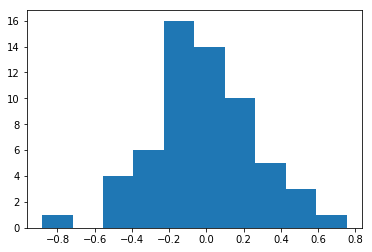

In [6]:
reg = LinearRegression().fit(X,y)
plt.hist(y - reg.predict(X))

### QQPlot on residual 

The QQ-Plot above shows the empirical residual is close to symmetric but with heavy tails (which verifies our assumption: FC is a ratio and unlikely to have a Gaussian noise). However, not much can really be done about it in terms of modeling (by simply multiplying the standard FC value to labels cannot give us a normal noise), but it may help with interpretation.

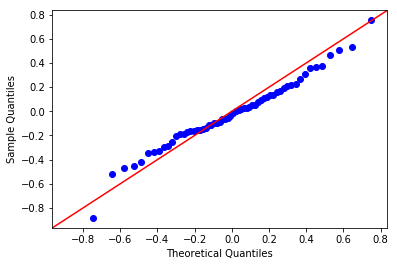

In [7]:
sm.qqplot(y-reg.predict(X), line='45', scale = 0.35)

#pylab.show()
pylab.savefig('qqplot.png')

## General Model Framework

We will compare Linear Regression, Kernel Ridge Regression and Gaussian Process Regression model below, using packages in sklearn library. The evaluation method is R2 score. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [8]:
def regression(model, X, y,is_print = True, is_plot = True):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    reg = model
    reg.fit(X_train,y_train)
    train_predict = reg.predict(X_train)
    test_predict = reg.predict(X_test)

    train_score = reg.score(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    
    if is_print:
        print('Model: ', str(model))
        print('train score: ', train_score)
        print('test score: ', test_score)
    
    if is_plot:
        plt.plot(test_predict, y_test, 'r.', label = 'test')
        plt.plot(train_predict, y_train, 'b.', label = 'train')
        plt.plot([0,2], [0,2], '--')
        plt.plot([0,2], [1,1], 'k--')
        plt.plot([1,1], [0,2], 'k--')
        plt.xlabel('prediction')
        plt.ylabel('true')
        plt.xlim(0,2)
        plt.ylim(0,2)
        plt.legend()
        
    return test_score

### Linear regression


Model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
train score:  0.7685109930382291
test score:  0.7411726652568567


0.7411726652568567

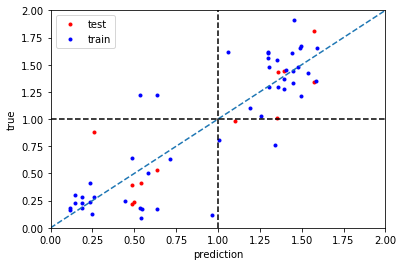

In [9]:
regression(LinearRegression(), X, y)

 ### Kernel Ridge

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)
train score:  0.6832510522293269
test score:  0.614723108043854


0.614723108043854

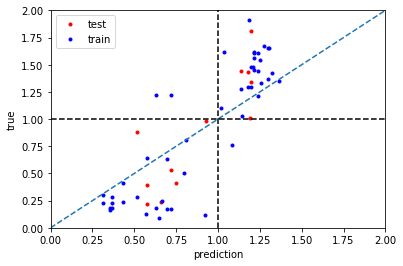

In [10]:
regression(KernelRidge(kernel = 'rbf'), X, y)

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)
train score:  0.7672029332962823
test score:  0.745743092642517


0.745743092642517

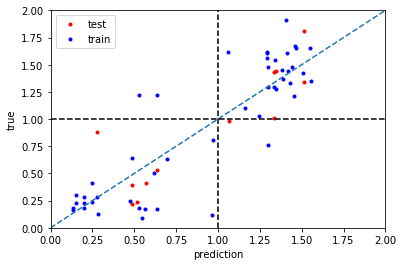

In [16]:
regression(KernelRidge(kernel = 'linear'), X, y)

### Gaussian Process Regression

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=2), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)
train score:  0.9335498788584558
test score:  0.44968446093294157


0.44968446093294157

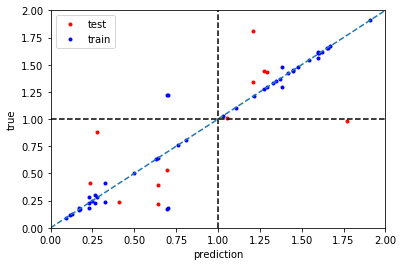

In [11]:
regression(GaussianProcessRegressor(kernel=RBF(2)), X, y)

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)
train score:  0.7685632155202883
test score:  0.7411887716467636


0.7411887716467636

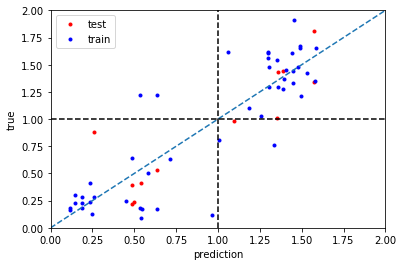

In [20]:
regression(GaussianProcessRegressor(kernel= DotProduct()), X, y)

### Picking a good gamma value (tune bandwidth of rbf kernel)

use the idea and code from https://github.com/chengsoonong/didbits/blob/master/Estimation/SVM_rbf_gamma.ipynb

To pick a good ``gamma`` value, we would use cross validation. To do cross validation, we need to know what range sensible ``gamma`` values lie in.
To find this range, we use a heuristic.
We want the influence of each datapoint to extend over some but not all of the dataset -- that is, we want ``gamma`` to be some value such that $\gamma||x-y||^2$ is neither very large nor very small.

We thus want $\frac{1}{\gamma}$ to be of similar magnitude to "typical" values of $||x-y||^2$.

In the sklearn library, RBF is defined with length scale $\alpha$, $$k(x_i, x_j) = exp(-1 / 2 d(x_i / \alpha, x_j / \alpha)^2)$$

thus $\alpha = 1/ \sqrt{2\gamma}$

In [12]:
pairs = itertools.combinations(X.as_matrix(), r=2)
distances = [np.linalg.norm(a-b)**2 for a,b in pairs]
distances.sort()
gamma_values = np.unique(distances)
alpha_values = list(np.sqrt(1.0/2 * gamma_values))
alpha_values.extend([0.001, 0.01, 40, 400])

print('gamma values: ', gamma_values)
print('alpha values: ', alpha_values)

gamma values:  [ 0.  2.  4.  6.  8. 10. 12.]
alpha values:  [0.0, 1.0, 1.4142135623730951, 1.7320508075688772, 2.0, 2.23606797749979, 2.449489742783178, 0.001, 0.01, 40, 400]


We see that the distances between oints in the dataset are discrete and from 0 to 12. Alpha values are between 0 and 2.5. We show the performance of Gaussian process with these ``gamma`` values. 

We also extend the ``gamma`` values of 0.001, 0.01, 40, 400 to values outside this range.

In [13]:
test_scores = []
for alpha in alpha_values:
    if alpha != 0:
        score = regression(GaussianProcessRegressor(kernel=RBF(alpha)), X, y, is_print=False, is_plot = False)
        test_scores.append(score)
test_scores

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-10645.28409195]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2430.93181419]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 44, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)


[-1.534879494623354,
 0.5467493474214127,
 0.5501279868643135,
 0.44968446093294157,
 -1.534879494623354,
 0.3757466949339278,
 -1.534879494623354,
 -1.534879494623354,
 -1.534879494623354,
 -1.534879494623354]

From above we observe alpha from 1 to have a high test R2 score, then we try alpha inside of np.arange(1,2,0.1)

In [14]:
test_scores = []

for alpha in np.arange(1,2,0.1):
    if alpha != 0:
        score = regression(GaussianProcessRegressor(kernel=RBF(alpha)), X, y, is_print=False, is_plot = False)
        test_scores.append(score)
        
test_scores

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1437.58255196]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)


[-1.534879494623354,
 -1.5160390508772201,
 0.5540270148183457,
 -1.534879494623354,
 0.5481878282598727,
 0.5351272683335561,
 -1.534879494623354,
 0.5448009425573644,
 -1.534879494623354,
 -1.534879494623354]

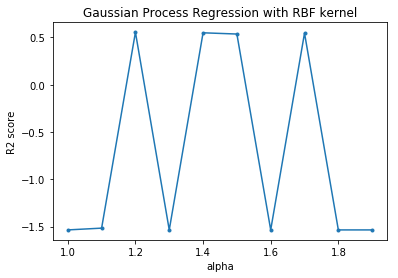

In [15]:
plt.plot(np.arange(1,2,0.1), test_scores, '.-')
plt.xlabel('alpha')
plt.ylabel('R2 score')
plt.title('Gaussian Process Regression with RBF kernel')

It's weird there seems to be no continuous regions of alpha providing a relatively high R2 score. But in all, there is no alpha can let GPR give more than 0.5 R2 test score, while the train score is high (around 0.9). The GPR model is overfit to training data. 